In [10]:
import cv2
import numpy as np

# https://stackoverflow.com/a/41075028
def contrast_enhancement(img):
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    # feel free to try different values for the limit and grid size:
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color spcae
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    # Stacking the original image with the enhanced image
    return enhanced_img

def kmeans(image):
    # Create a feature vector using the color information of each pixel
    features = image.reshape(-1, 3).astype(np.float32)

    # Perform K-means clustering on the feature vector
    num_clusters = 2 # you can set this value to the number of clusters you want
    kmeans = cv2.kmeans(
        features, num_clusters, None, 
        criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1.0), 
        attempts=20, 
        flags=cv2.KMEANS_PP_CENTERS
    )

    # Extract the cluster labels from the K-means output
    labels = kmeans[1].flatten().reshape(image.shape[:-1])

    # Create a label map from the cluster labels
    kmeans_clustering = np.zeros_like(image, shape=(image.shape[:-1]), dtype=np.uint8)
    for i, label in enumerate(np.unique(labels)):
        kmeans_clustering[np.where(labels == label)] = i

    return kmeans_clustering

In [11]:
from isodata import isodata_classification
import matplotlib.pyplot as plt
import matplotlib

def isodata(image):
    """
        + number of clusters desired.
        K = 15
        + max number of iterations.
        I = 100
        + max number of pairs of clusters which can be merged.
        P = 2
        + threshold value for min number in each cluster.
        THETA_M = 10
        + threshold value for standard deviation (for split). 
        THETA_S = 0.1
        + threshold value for pairwise distances (for merge).
        THETA_C = 2
        + threshold change in the clusters between each iter.
        THETA_O = 0.01
    """
    params = { "K": 2, }

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # run Isodata
    return isodata_classification(gray, parameters=params)

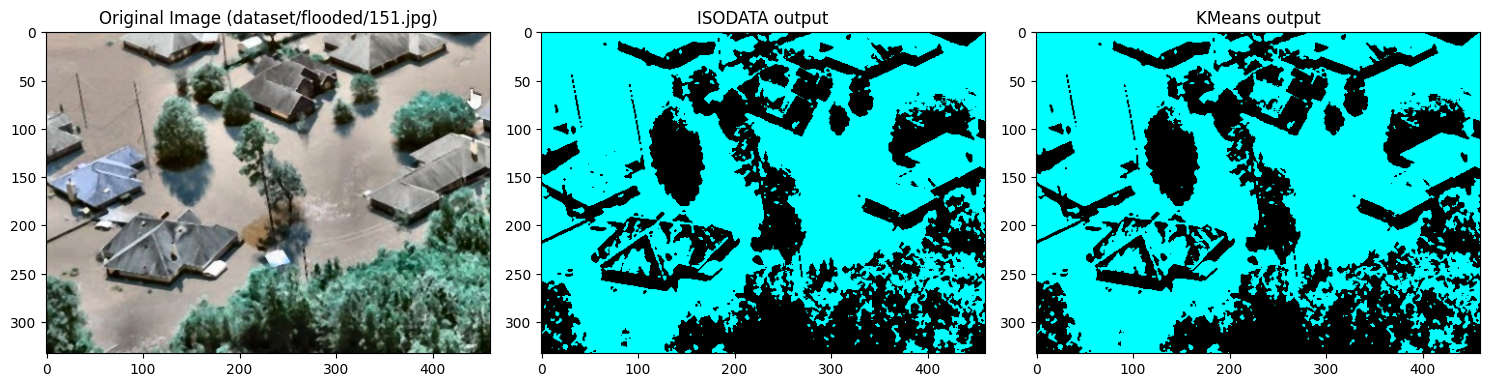

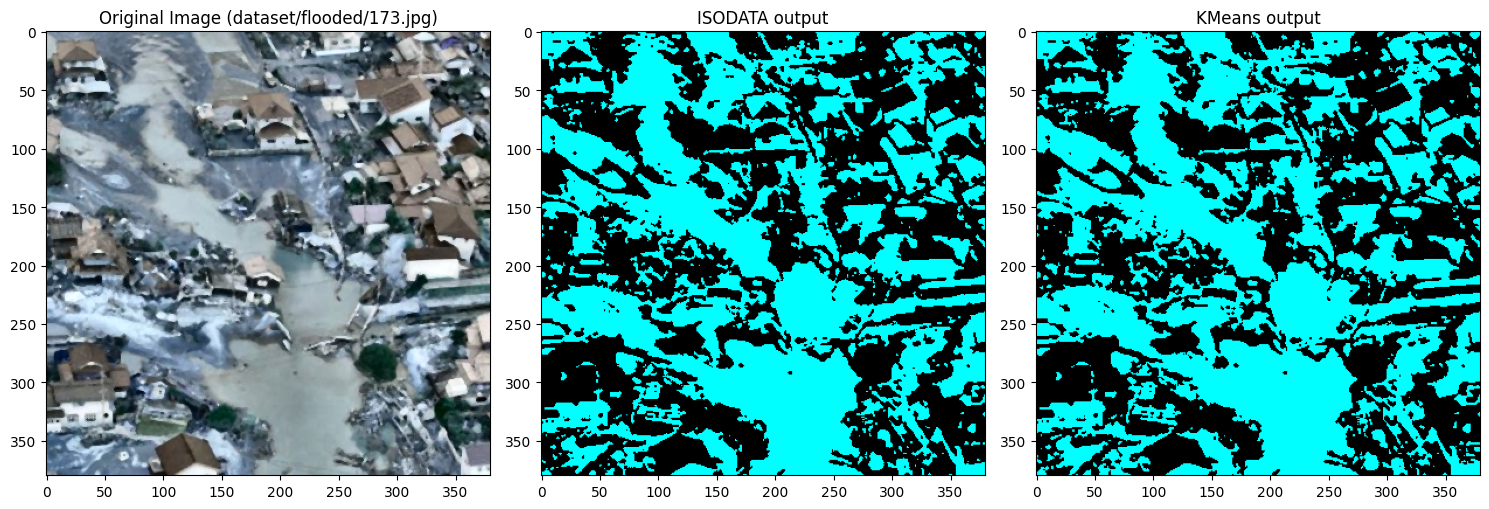

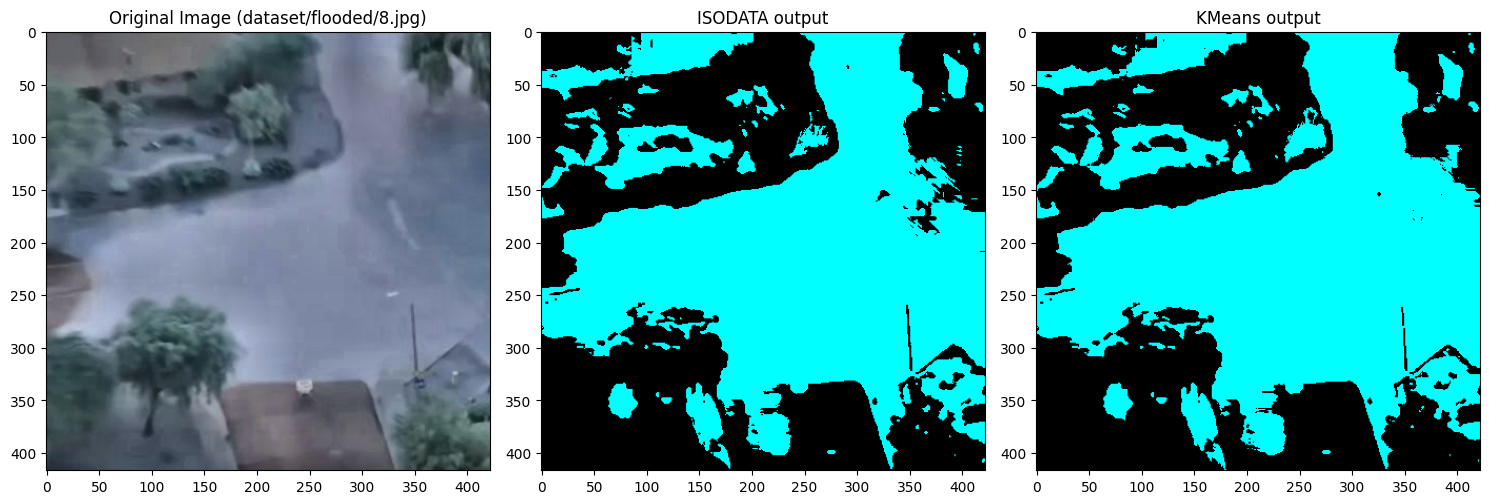

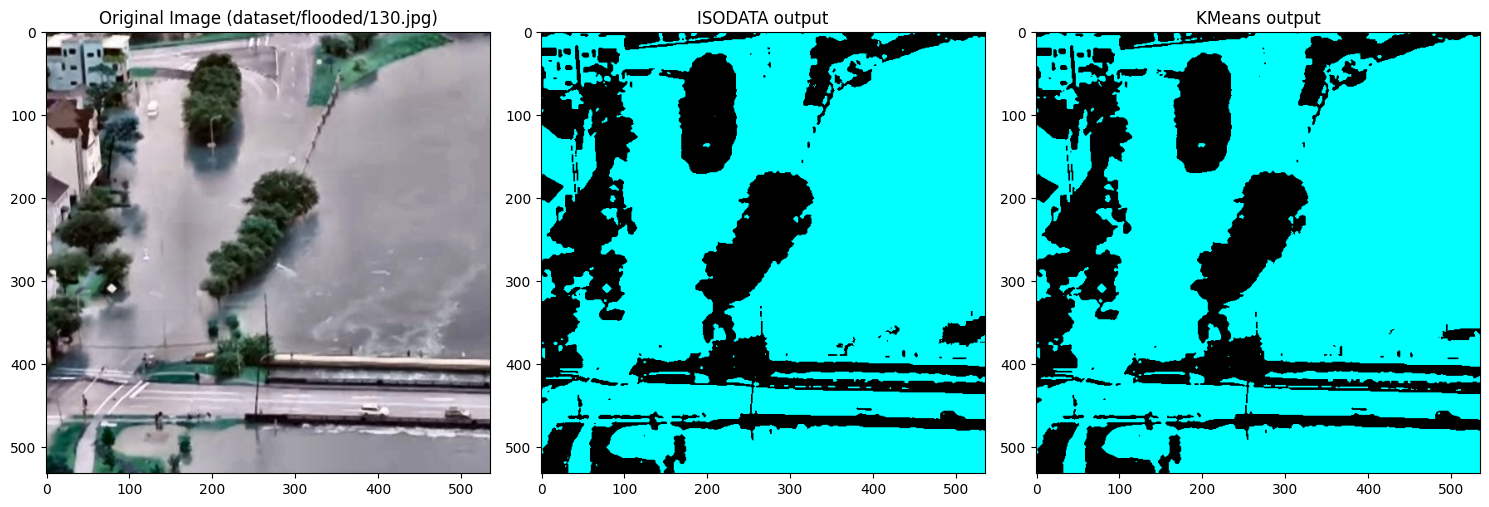

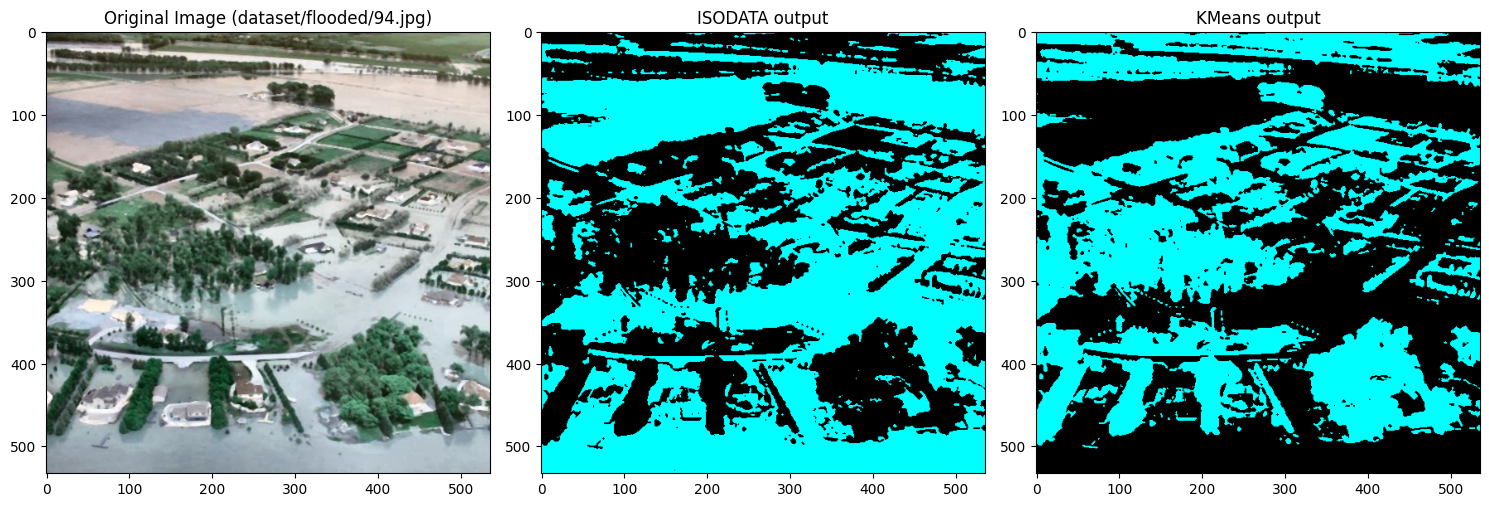

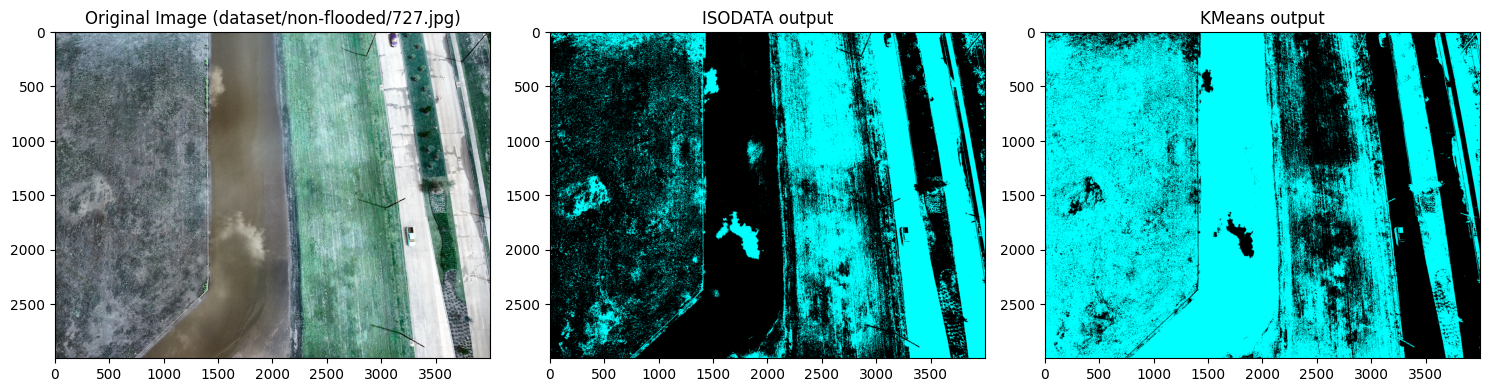

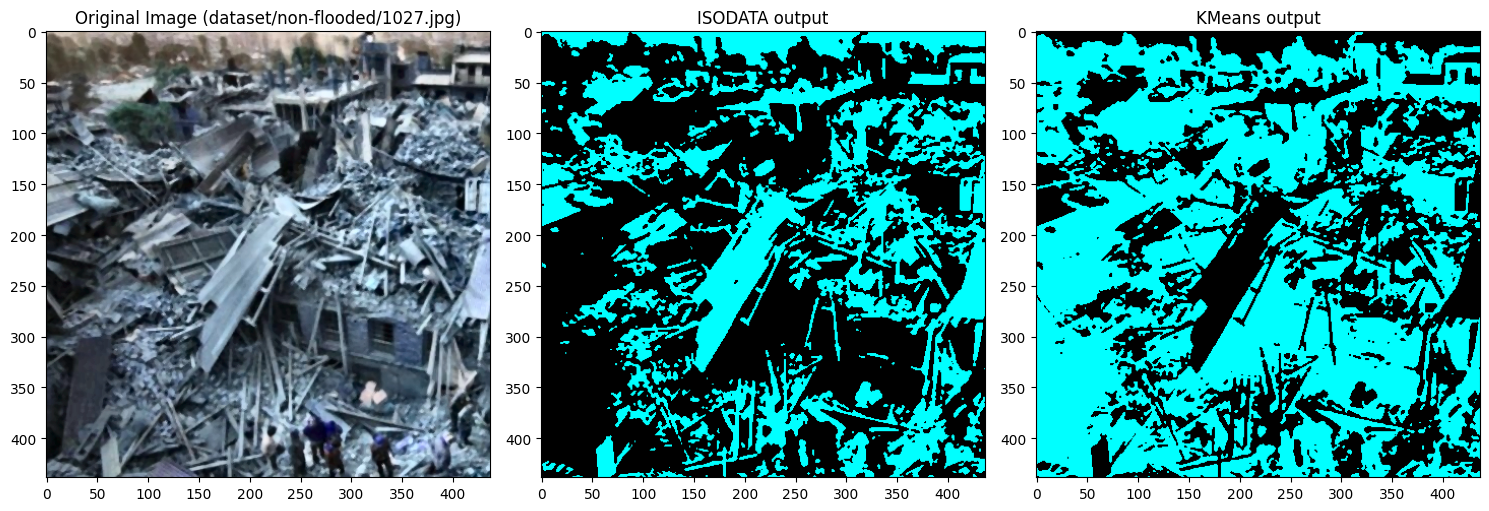

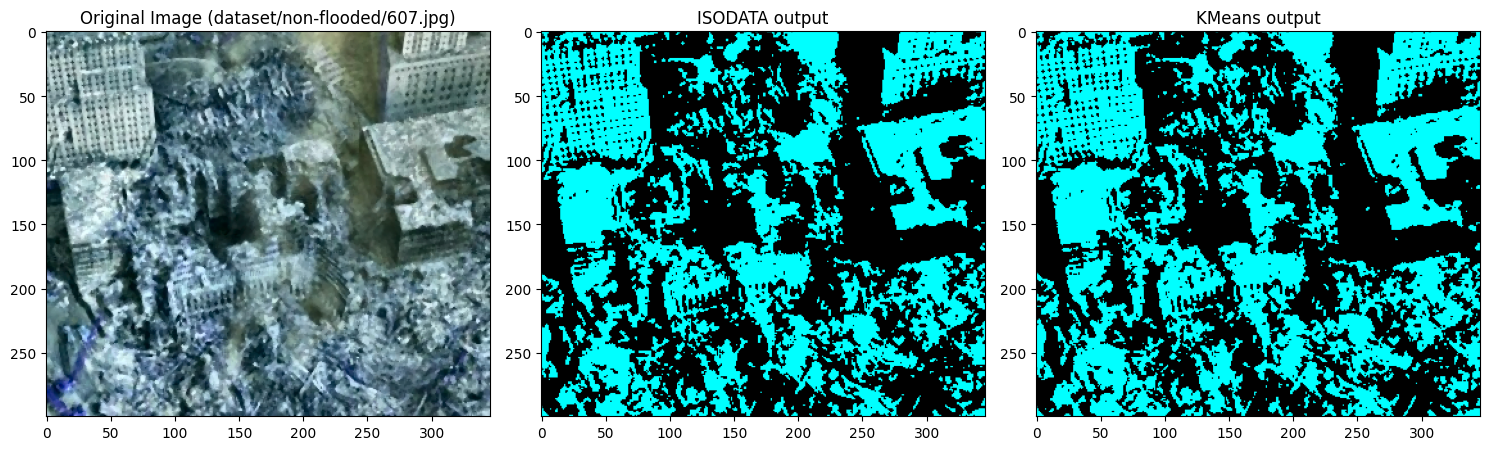

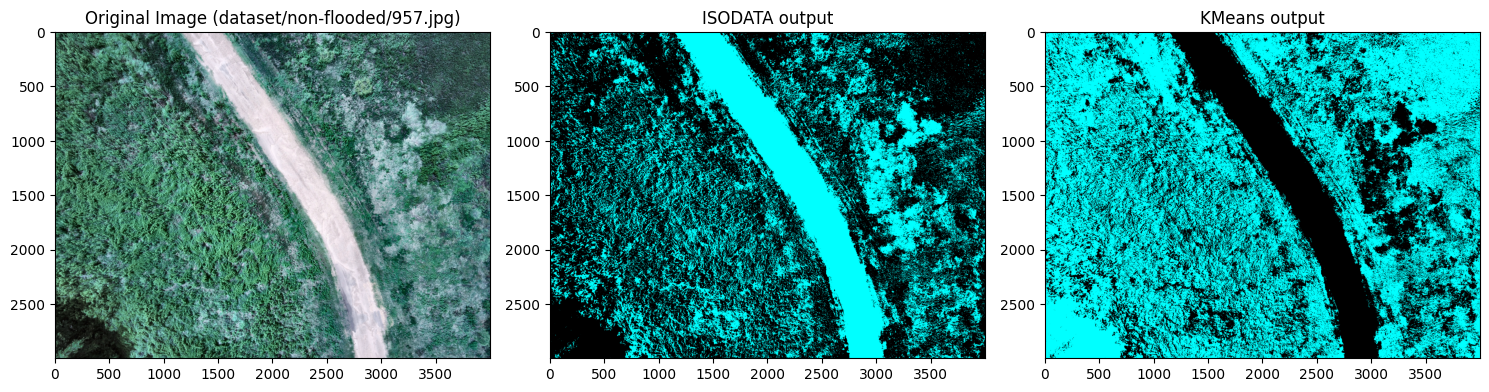

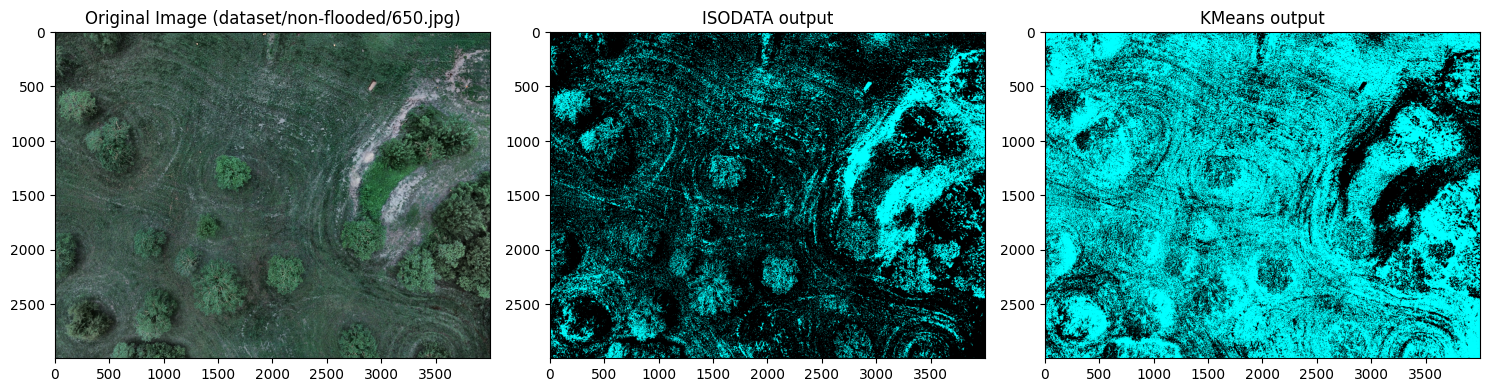

In [12]:
color_map = np.array([
    (0, 0, 0),
    (0, 255, 255),   # aqua
    (0, 0, 255),     # blue
    (0, 255, 0),     # green
    (255, 0, 0),     # red
    (255, 255, 0),   # yellow
    (0, 255, 255),   # cyan
    (255, 0, 255),   # magenta
    (192, 192, 192), # silver
    (128, 128, 128), # gray
    (128, 0, 0),     # maroon
    (128, 128, 0),   # olive
    (0, 128, 0),     # dark green
    (128, 0, 128),   # purple
    (0, 128, 128),   # teal
    (0, 0, 128),     # navy
    (255, 255, 255), # white
    (255, 165, 0),   # orange
    (255, 192, 203), # pink
    (0, 255, 0),     # lime green
    (255, 0, 255),   # fuchsia
    (0, 128, 128),   # turquoise
])

import os
flooded_dir = 'dataset/flooded'
nonflooded_dir = 'dataset/non-flooded/'
first_5_flooded = os.listdir(flooded_dir)[:5]
first_5_nonflooded = os.listdir(nonflooded_dir)[:5]


for i, row in enumerate(range(10)):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    img = ( 
        os.path.join(flooded_dir, first_5_flooded[i]) if i < 5 
        else os.path.join(nonflooded_dir, first_5_nonflooded[i-5])
    )

    image = cv2.imread(img) 
    image = cv2.medianBlur(image, 3)
    image = contrast_enhancement(image)

    isodata_clustering = isodata(image)
    kmeans_clustering = kmeans(image)

    # ISODATA seems to have reversed labels?
    isodata_segmented = color_map[isodata_clustering]
    kmeans_segmented = color_map[kmeans_clustering.max() - kmeans_clustering]

    # Display the original image and the segmented image side by side using matplotlib
    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0].set_title(f'Original Image ({img})')

    ax[1].imshow(isodata_segmented)
    ax[1].set_title('ISODATA output')

    ax[2].imshow(kmeans_segmented)
    ax[2].set_title('KMeans output')

    plt.tight_layout()
    plt.show()
